### Create a Neural Network with pytorch for RL

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from collections import deque, namedtuple
import random
import math
from itertools import count

import matplotlib
import matplotlib.pyplot as plt

import gymnasium as gym

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Basic model that recieves the observation and returns an action
layers = nn.Sequential(
    nn.Linear(8, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 4),
    nn.Softmax(dim=1)
)

# Create a model for reinforcement learning
class DQN(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)
    
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

policy_net = DQN(layers).to(device)
target_net = DQN(layers).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

memory = ReplayMemory(10000)

In [17]:
max_episodes = 10
batch_size = 64

epsilon = 1.0  # Exploration rate
epsilon_min = 0.1  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate

lr = 0.001
gamma = 0.99

steps_done = 0
episode_durations = []

env = gym.make("LunarLander-v3")

In [18]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [19]:
def choose_action(observation, action_space):
    global steps_done
    sample = random.random()
    eps_treshold = epsilon_min + (epsilon - epsilon_min) * math.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if sample > eps_treshold:
        with torch.no_grad():
            return policy_net(observation).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long)
    
def learn():
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    done_batch = torch.cat(batch.done)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = target_net(next_state_batch).max(1)[0].detach()

    expected_state_action_values = next_state_values * gamma + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Run the test environment

#### Lunar Lander Environment

- Observation Space: 8
    1. X position of the lander
    2. Y position of the lander
    3. X velocity of the lander
    4. Y velocity of the lander
    5. Angle of the lander
    6. Angular velocity of the lander
    7. Left Leg Contact (0 or 1)
    8. Right Leg Contact (0 or 1)

- Action Space: 4
    0. Do nothing
    1. Fire left Engine
    2. Fire main Engine
    3. Fire right Engine

- Rewards:
    - -100 for Collision
    - +100 for Landing

    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.



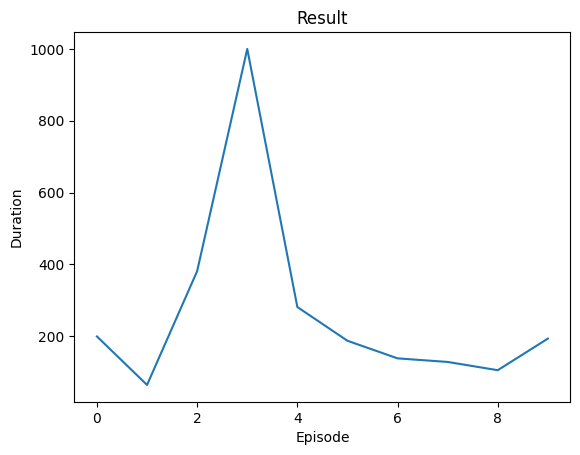

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
for episode in range(max_episodes):
    state, info = env.reset()
    frame = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0
    episode_over = False

    for t in count():
        action = choose_action(frame, env.action_space)
        observation, reward, terminated, truncated, info = env.step(action.item())
        total_reward += reward

        if terminated or truncated:
            next_frame = None
            episode_over = True
        else:
            next_frame = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            reward = torch.tensor([reward], device=device)
            done = torch.tensor([episode_over], device=device)

            memory.push(frame, action, reward, next_frame, done)

            frame = next_frame
            learn()
        
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * (1 - lr) + target_net_state_dict[key] * lr
    
        if episode_over:
            episode_durations.append(t + 1)
            plot_durations()
            break
    
    #if episode % 100 == 0:
    print(f'Episode {episode + 1}/{max_episodes}, Total Reward: {total_reward}', end='\r', flush=True)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

plot_durations(show_result=True)
plt.ioff()
plt.show()

In [22]:
env_human = gym.make("LunarLander-v3", render_mode="human")

for episode in range(10):
    state, info = env_human.reset()
    frame = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    episode_over = False
    while not episode_over:
        action = choose_action(frame, env_human.action_space)
        observation, reward, terminated, truncated, info = env_human.step(action.item())

        frame = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        if terminated or truncated:
            episode_over = True

env_human.close()